# Phone Plan Analysis - Megaline 2018

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

This project analyzes two different prepaid plans for Megaline- Surf and Ultimate. The goal is to find which plan brings in the most revenue so that Megaline can adjust the advertising budget. 
First, we will preprocess the data sets, analyze the users' behavior, then determine which plan brings in more revenue. 

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd 
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial

## Load data

In [2]:
# Load the data files into different DataFrames
calls = pd.read_csv('megaline_calls.csv')
internet = pd.read_csv('megaline_internet.csv')
messages = pd.read_csv('megaline_messages.csv')
plans = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users.csv')

## Prepare the data

## Plans

In [3]:
# Print the general/summary information about the plans' DataFrame
plans.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Print a sample of data for plans
plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


There are only two rows which makes since there are only two plans. The usd_per_message and usd_per_minute are both floats and the rest are integer or object. We can change the floats to integers. We will also convert mb_per_month_included to gb_to_month_included to keep the units of measurement the same. 

## Fix data

In [5]:
#changing the usd_per_message and usd_per_minute to integer 
plans = plans.astype({'usd_per_message':'int', 'usd_per_minute':'int'})

In [6]:
#making sure the changes have been made 
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   usd_monthly_pay        2 non-null      int64 
 4   usd_per_gb             2 non-null      int64 
 5   usd_per_message        2 non-null      int32 
 6   usd_per_minute         2 non-null      int32 
 7   plan_name              2 non-null      object
dtypes: int32(2), int64(5), object(1)
memory usage: 240.0+ bytes


## Enrich data

In [7]:
#dropping the column mb_per_month
plans.drop(['mb_per_month_included'], axis=1, inplace=True)

In [8]:
#adding it in again as gb_per_month 
plans.insert(1, 'gb_per_month_included', ['15','30'], True)
plans.head()

,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0,0,surf
1,1000,30,3000,70,7,0,0,ultimate


## Users

In [9]:
# Print the general/summary information about the users' DataFrame
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
# Print a sample of data for users
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [11]:
#looking at the format of churn_date
users['churn_date'].unique()

array([nan, '2018-12-18', '2018-11-16', '2018-09-07', '2018-12-30',
       '2018-10-07', '2018-12-31', '2018-11-24', '2018-11-11',
       '2018-12-12', '2018-11-14', '2018-12-27', '2018-11-29',
       '2018-12-22', '2018-11-30', '2018-10-13', '2018-07-31',
       '2018-12-15', '2018-12-19', '2018-10-03', '2018-10-22',
       '2018-08-16', '2018-12-26', '2018-09-01', '2018-11-21',
       '2018-08-19', '2018-12-10', '2018-09-17', '2018-11-18',
       '2018-09-18'], dtype=object)

The reg_date and churn_date are not in datetime type.They are in an object type. There is also a lot of missing data in the churn_date. From the given description of the data, the data here is missing because the calling plan was being used at the time this data was generated. We will change the churn_date to datetime and also fill in the missing values in the next steps.

### Fix Data

In [12]:
#changing reg_date and churn_date to datetime format
users[['reg_date', 'churn_date']] = users[['reg_date', 'churn_date']].apply(pd.to_datetime, format="%Y-%m-%d")

In [13]:
#checking changes have been made 
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


### Enrich Data

In [14]:
#looking at missing values for users df
users.isna().sum()

user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

In [15]:
#replacing missing values with not_applicable. We cannot throw out this data as it makes up for 93% of the data
users['churn_date'] = users['churn_date'].fillna('not_applicable')

In [16]:
#checking to see if changes have been made 
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,not_applicable
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,not_applicable
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,not_applicable
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,not_applicable


## Calls

In [17]:
# Print the general/summary information about the calls' DataFrame
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [18]:
# Print a sample of data for calls
calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


The call_date column is also not in datatime format which we can fix.

### Fix data

In [19]:
#changing call_date to datetime format
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")
calls['month'] = pd.DatetimeIndex(calls['call_date']).month

In [20]:
#rounding up duration to nearest whole number
calls['duration'] = np.ceil(calls['duration'])

In [21]:
#making sure it is changed 
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.3+ MB


In [22]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


## Messages

In [23]:
# Print the general/summary information about the messages' DataFrame
messages.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [24]:
# Print a sample of data for messages
messages.head()


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


There is no missing data. The message_date is not in datetime format and can be changed. 

### Fix data

In [25]:
#changing the message_date to datetime 
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [26]:
#checking to make sure the format has been applied 
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

In [27]:
# Print the general/summary information about the internet DataFrame
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [28]:
# Print a sample of data for the internet traffic
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


The session_date column is not in datetime format which we can change. We can also change mb_used to gb_used so that the units  of measurement stay the same. We can also change the dtype to integer so that we can do calculations later. 

### Fix data

In [29]:
#changing to datetime format
internet['session_date'] = pd.to_datetime(internet['session_date'] , format="%Y-%m-%d")

In [30]:
#making sure the changes have been applied 
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enrich data

In [31]:
#making sure it has been applied 
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [32]:
#looking at the changes to make sure they have been made 
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


## Study plan conditions

In [33]:
# Print out the plan conditions and make sure they are clear for you
plans.head()


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15,500,20,10,0,0,surf
1,1000,30,3000,70,7,0,0,ultimate


## Aggregate data per user



In [34]:
#looking at the calls df again 
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


In [35]:
# Calculate the number of calls made by each user per month. Save the result.
calls_per_user = calls.groupby(['user_id', 'month'])['user_id'].agg(['count']).reset_index()
calls_per_user.columns = ['user_id', 'month', 'total_calls']
calls_per_user 

,user_id,month,total_calls
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


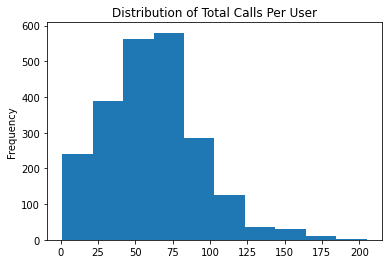

In [36]:
#looking at the distribution of total calls per user
calls_per_user['total_calls'].plot(kind='hist',
                    title='Distribution of Total Calls Per User',
                    legend=False,
                    );


The majority of users make between 50 to about 70 calls per month 

In [37]:
# Calculate the amount of minutes spent by each user per month. Save the result.
#Grouping calls table and finding total duration of calls per user per month
minutes_per_user = calls.groupby(['user_id', 'month'])['duration'].agg(['sum']).reset_index()
minutes_per_user.columns = ['user_id', 'month', 'total_duration']
minutes_per_user


,user_id,month,total_duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


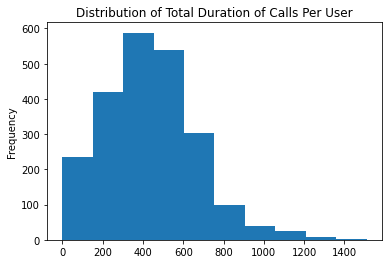

In [38]:
#looking at the distribution of duration of calls per user
minutes_per_user['total_duration'].plot(kind='hist',
                    title='Distribution of Total Duration of Calls Per User',
                    legend=False,
                    );

The majority of users spend between about 400 minutes on the phone per month. 

In [39]:
#adding just the month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [40]:
messages.head()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12


In [41]:
# Calculate the number of messages sent by each user per month. Save the result.
texts_per_user = messages.groupby(['user_id', 'month'])['user_id'].agg(['count']).reset_index()
texts_per_user.columns = ['user_id', 'month', 'total_texts']
texts_per_user


,user_id,month,total_texts
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


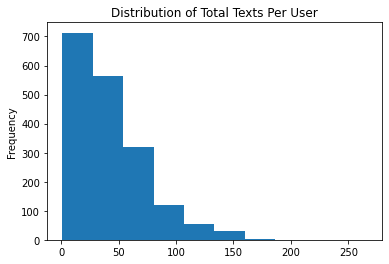

In [42]:
#looking at the distribution of texts per user
texts_per_user['total_texts'].plot(kind='hist',
                    title='Distribution of Total Texts Per User',
                    legend=False,
                    );

Majority of users send between 0-25 texts messages per month. 

In [43]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [44]:
#converting mb to gb and changing to int dtype, rounding up to nearest whole number
internet['gb_used'] = (internet['mb_used']/1024)

In [45]:
#adding just the month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet.head()

,id,user_id,session_date,mb_used,gb_used,month
0,1000_13,1000,2018-12-29,89.86,0.087754,12
1,1000_204,1000,2018-12-31,0.00,0.000000,12
2,1000_379,1000,2018-12-28,660.40,0.644922,12
3,1000_413,1000,2018-12-26,270.99,0.264639,12
4,1000_442,1000,2018-12-27,880.22,0.859590,12


In [46]:
#grouping the internet df and finding total gb per user per month
gb_per_user = internet.groupby(['user_id', 'month'])['gb_used'].sum().reset_index()
gb_per_user.columns = ['user_id', 'month', 'total_gb_used']
gb_per_user

,user_id,month,total_gb_used
0,1000,12,1.856904
1,1001,8,6.756982
2,1001,9,13.002754
3,1001,10,21.807119
4,1001,11,18.070605
...,...,...,...
2272,1498,12,22.595400
2273,1499,9,12.680430
2274,1499,10,19.035576
2275,1499,11,16.419756


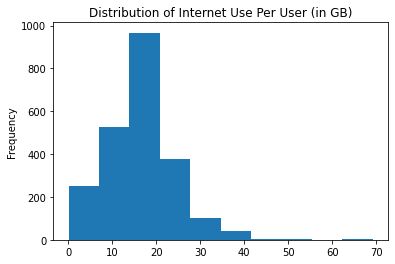

In [47]:
gb_per_user['total_gb_used'].plot(kind='hist',
                    title='Distribution of Internet Use Per User (in GB)',
                    legend=False,
                    );

The majority of users use about 40-50gb per month of data. 

In [48]:
calls.head()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12


In [49]:
# Merge the data for calls, minutes, messages, internet based on user_id 
df1 = calls_per_user.merge(minutes_per_user, on=['user_id', 'month'], how='outer').merge(texts_per_user, on=['user_id', 'month'], how='outer').merge(gb_per_user, on=['user_id', 'month'], how='outer')
df1

,user_id,month,total_calls,total_duration,total_texts,total_gb_used
0,1000,12,16.0,124.0,11.0,1.856904
1,1001,8,27.0,182.0,30.0,6.756982
2,1001,9,49.0,315.0,44.0,13.002754
3,1001,10,65.0,393.0,53.0,21.807119
4,1001,11,64.0,426.0,36.0,18.070605
...,...,...,...,...,...,...
2288,1349,12,NaN,NaN,61.0,12.734287
2289,1361,5,NaN,NaN,2.0,1.484072
2290,1482,10,NaN,NaN,2.0,NaN
2291,1108,12,NaN,NaN,NaN,0.227705


In [50]:
df1.fillna(0, inplace=True)
df1

,user_id,month,total_calls,total_duration,total_texts,total_gb_used
0,1000,12,16.0,124.0,11.0,1.856904
1,1001,8,27.0,182.0,30.0,6.756982
2,1001,9,49.0,315.0,44.0,13.002754
3,1001,10,65.0,393.0,53.0,21.807119
4,1001,11,64.0,426.0,36.0,18.070605
...,...,...,...,...,...,...
2288,1349,12,0.0,0.0,61.0,12.734287
2289,1361,5,0.0,0.0,2.0,1.484072
2290,1482,10,0.0,0.0,2.0,0.000000
2291,1108,12,0.0,0.0,0.0,0.227705


In [51]:
# Add the plan information, merging user information to df1 to have one large complete df with all info
df2 = df1.merge(users, on='user_id', how='outer')
df2.head()

,user_id,month,total_calls,total_duration,total_texts,total_gb_used,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,12.0,16.0,124.0,11.0,1.856904,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,not_applicable
1,1001,8.0,27.0,182.0,30.0,6.756982,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable
2,1001,9.0,49.0,315.0,44.0,13.002754,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable
3,1001,10.0,65.0,393.0,53.0,21.807119,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable
4,1001,11.0,64.0,426.0,36.0,18.070605,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable


In [52]:
# Calculate the monthly revenue for each user
def monthly_revenue(row):
    additional_mins = 0
    additional_message = 0
    additional_data_gb = 0
    surf_base = 20
    ultimate_base = 70
    plan = row['plan']
    if plan == 'surf':
        if row['total_duration'] > 500:
            additional_mins = row['total_duration'] - 500
        if row['total_texts'] > 50:
            additional_message = row['total_texts'] - 50
        if row['total_gb_used'] > 15:
            additional_data_gb = row['total_gb_used'] - 15
        profit = np.ceil((additional_mins * 0.03) + (additional_message * 0.03) + (additional_data_gb * 10))
        if profit == 0:
            return surf_base
        else:
            return profit + surf_base
    if plan == 'ultimate':
        if row['total_duration'] > 3000:
            additional_mins = row['total_duration'] - 3000
        if row['total_texts'] > 1000:
            additional_message = row['total_texts'] - 1000
        if row['total_gb_used'] > 30:
            additional_data_gb = row['total_gb_used'] - 30
        profit = np.ceil((additional_mins * 0.01) + (additional_message * 0.01) + (additional_data_gb * 7))
        if profit == 0:
            return ultimate_base
        else:
            return profit + ultimate_base

In [53]:
#applying the function to df4, append each row, result store in new column 'monthly_revenue'
df2['monthly_revenue_per_user'] = df2.apply(monthly_revenue, axis = 1)
df2.head()

,user_id,month,total_calls,total_duration,total_texts,total_gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,monthly_revenue_per_user
0,1000,12.0,16.0,124.0,11.0,1.856904,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,not_applicable,70.0
1,1001,8.0,27.0,182.0,30.0,6.756982,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,20.0
2,1001,9.0,49.0,315.0,44.0,13.002754,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,20.0
3,1001,10.0,65.0,393.0,53.0,21.807119,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,89.0
4,1001,11.0,64.0,426.0,36.0,18.070605,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,51.0


## Study user behaviour

### Calls

In [54]:
#using a pivot table to look at the mean per plan per each distinct month for duration of calls
avg_duration_pivot = df2.pivot_table(index='month',
                                     values='total_duration',
                                     columns='plan',
                                     aggfunc='mean')
avg_duration_pivot 

plan,surf,ultimate
month,,
1.0,203.000000,193.500000
2.0,297.000000,403.142857
3.0,330.000000,304.250000
4.0,351.540000,336.857143
5.0,399.584416,406.241379
6.0,431.298969,370.957447
7.0,449.983471,427.067797
8.0,410.111111,421.436620
9.0,414.226804,437.511628


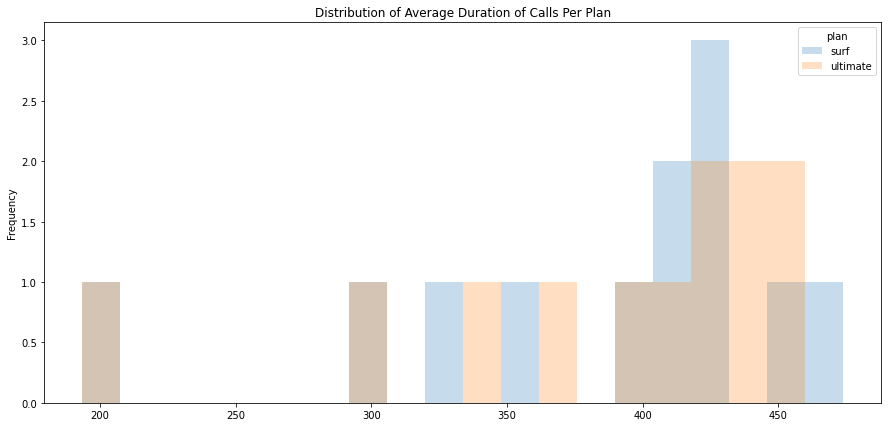

In [55]:
#comparing the number of  minutes for users of each plan for each month in histogram
avg_duration_pivot.plot(kind='hist',
                    title='Distribution of Average Duration of Calls Per Plan',
                    bins=20,
                    alpha=0.25,
                    figsize=(15,7)
                    );

It seems that Surf plan users tend to make more calls per month in general.  

In [56]:
# Calculate the standard deviation and the variance of the monthly call duration
call_std_var_pivot = df2.pivot_table(index='month',
                                      values='total_duration',
                                      columns='plan',
                                      aggfunc=['var', 'std'])
call_std_var_pivot 

var                       std            
plan           surf      ultimate        surf    ultimate
month                                                    
1.0    15842.000000  16572.333333  125.865007  128.733575
2.0    52226.500000  76889.476190  228.531179  277.289517
3.0    35809.363636  61984.931818  189.233622  248.967732
4.0    50866.743265  34888.928571  225.536567  186.785783
5.0    59754.219754  43841.046798  244.446763  209.382537
6.0    45592.628436  42503.563367  213.524304  206.163924
7.0    61005.099725  72563.374635  246.992105  269.375898
8.0    54344.645963  53645.506640  233.119381  231.614997
9.0    46595.958656  57070.464569  215.860971  238.894254
10.0   52278.664056  54261.910512  228.645280  232.941861
11.0   51607.021602  60593.222847  227.171789  246.156907
12.0   63629.518918  62503.783400  252.248923  250.007567

The variance and standard deviation for both plans are generally high which means that the distribution of data is far from the mean. 

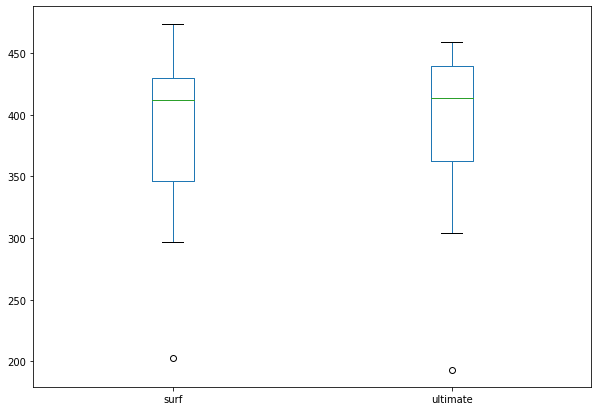

In [57]:
# Plot a boxplot to visualize the distribution of the monthly call duration
avg_duration_pivot.plot(kind='box',
                        figsize=(10,7));


Both plans have outliers. The Ultimate's plan median for calls is slightly higher. The Surf plan's range here is slightly higher than Ultimate. 

##### Conclusion: Surf plan users tend to make more calls overall than Ultimate plan users. 

### Messages

In [58]:
# Comparing the number of messages users of each plan tend to send each month
avg_texts_pivot = df2.pivot_table(index='month',
                                     values='total_texts',
                                     columns='plan',
                                     aggfunc='mean')
avg_texts_pivot 


plan,surf,ultimate
month,,
1.0,10.500000,15.500000
2.0,12.000000,21.571429
3.0,15.260870,20.250000
4.0,17.400000,22.047619
5.0,24.012987,32.103448
6.0,25.298969,29.340426
7.0,27.033058,32.830508
8.0,28.777778,38.478873
9.0,30.762887,37.895349


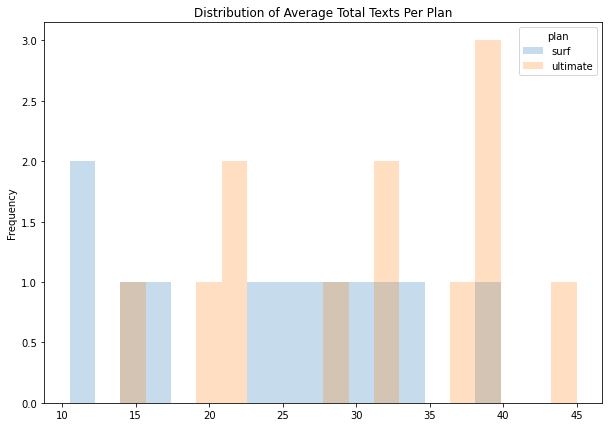

In [59]:
#plotting distribution of mean of total texts per plan in histogram
avg_texts_pivot.plot(kind='hist',
                     title='Distribution of Average Total Texts Per Plan',
                     bins=20,
                     alpha=0.25,
                     figsize=(10,7));

Ultimate plan users text more than Surf plan users. 

In [60]:
#calculating the standard deviation and variance of monthly texts per plan 
text_var_std_pivot = df2.pivot_table(index='month',
                                      values='total_texts',
                                      columns='plan',
                                      aggfunc=['var', 'std'])
text_var_std_pivot

var                     std           
plan          surf     ultimate       surf   ultimate
month                                                
1.0     220.500000   313.666667  14.849242  17.710637
2.0     386.000000   478.285714  19.646883  21.869744
3.0     346.565217   654.386364  18.616262  25.580977
4.0     501.591837   544.147619  22.396246  23.326972
5.0     847.197198  1297.310345  29.106652  36.018195
6.0     914.920103   857.620722  30.247646  29.285162
7.0     923.915565   960.488019  30.395979  30.991741
8.0    1029.515528  1196.367404  32.086064  34.588544
9.0    1003.829496  1050.918331  31.683268  32.417871
10.0   1275.465708  1221.106289  35.713663  34.944331
11.0   1065.344034  1232.669166  32.639608  35.109389
12.0   1458.158612  1549.419956  38.185843  39.362672

The variance and standard deviation for both plans are very high which means that the distribution of data is far from the mean.

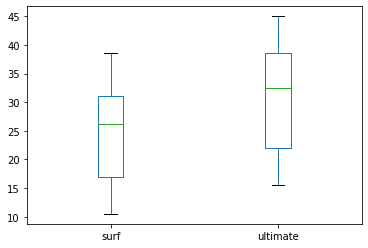

In [61]:
#plotting the two means of texts per month per plan in a box plot 
avg_texts_pivot.plot(kind='box');

#### Conclusion: We can infer that there are differences between both plans regarding texts, with Ultimate having a higher median than Surf. Ultimate users text more.

### Internet

In [62]:
# Comparing the amount of internet traffic consumed by users per plan each month 
avg_gb_pivot = df2.pivot_table(index='month',
                               columns='plan',
                               values='total_gb_used')
avg_gb_pivot

plan,surf,ultimate
month,,
1.0,4.760605,6.755950
2.0,11.893402,16.727352
3.0,13.032656,17.892108
4.0,11.703323,15.743803
5.0,13.609722,16.234846
6.0,14.942900,14.978439
7.0,16.390235,15.961664
8.0,16.401691,17.397188
9.0,16.202570,16.572138


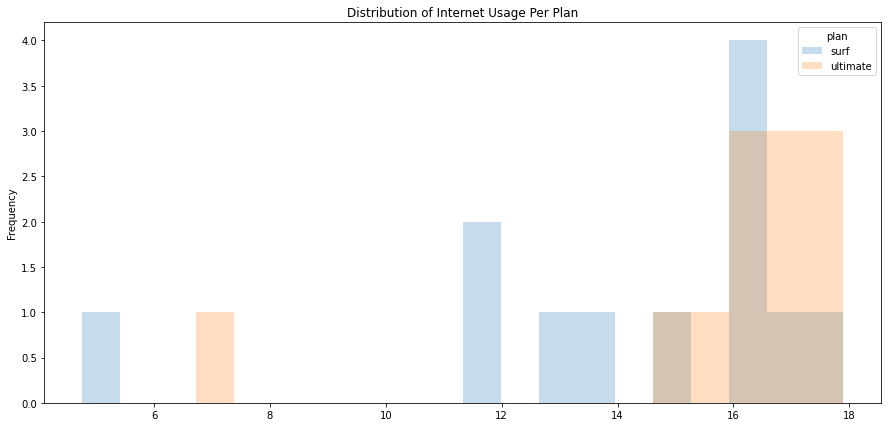

In [63]:
#looking at the distribution of internet usage (in GB) per month per plan 
avg_gb_pivot.plot(kind='hist',
                  title='Distribution of Internet Usage Per Plan',
                  figsize=(15,7),
                  bins=20,
                  alpha=0.25);

We can see that the Ultimate plan users distribution is slightly wider. 

In [64]:
#calculating the standard deviation and variance of monthly gb used per plan 
gb_var_std_pivot = df2.pivot_table(index='month',
                                      values='total_gb_used',
                                      columns='plan',
                                      aggfunc=['var', 'std'])
gb_var_std_pivot

var                   std           
plan        surf    ultimate      surf   ultimate
month                                            
1.0    17.394976   15.635216  4.170728   3.954139
2.0    41.649779   35.904976  6.453664   5.992076
3.0    65.084035  133.837858  8.067468  11.568831
4.0    56.309643   84.332091  7.503975   9.183251
5.0    58.628592   54.159275  7.656931   7.359299
6.0    46.857252   68.678409  6.845236   8.287244
7.0    61.689899   65.249644  7.854292   8.077725
8.0    71.178902   57.646831  8.436759   7.592551
9.0    48.939371   47.053374  6.995668   6.859546
10.0   59.631291   54.354932  7.722130   7.372580
11.0   54.526776   54.921606  7.384225   7.410911
12.0   68.805130   59.014608  8.294886   7.682097

Again, we can see that the variance and standard deviation is high for both plans. 

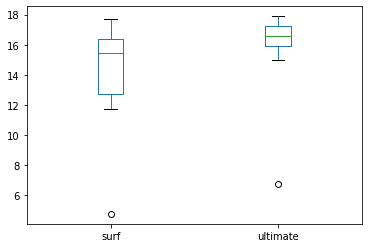

In [65]:
avg_gb_pivot.plot(kind='box');

The range and interquartile range for Surf users is much wider than Ultimate users. There are a few outliers for the Ultimate plan users. 

 #### Conclusion: We can see that Surf plan users overall use more data than Ultimate plan users. 

## Revenue

In [66]:
#comparing the mean monthly revenue per month per plan per user
revenue_pivot = df2.pivot_table(index='month',
                                columns='plan',
                                values='monthly_revenue_per_user')
revenue_pivot

plan,surf,ultimate
month,,
1.0,20.000000,70.000000
2.0,33.444444,70.000000
3.0,44.000000,73.500000
4.0,39.280000,72.857143
5.0,46.051948,70.517241
6.0,46.597938,71.510638
7.0,59.991736,71.864407
8.0,61.395062,72.704225
9.0,55.628866,71.837209


In [67]:
compare = df2.groupby('plan')['monthly_revenue_per_user'].aggregate(['sum', 'mean', 'median'])
compare

,sum,mean,median
plan,,,
surf,91436.0,57.907536,38.0
ultimate,52223.0,72.131215,70.0


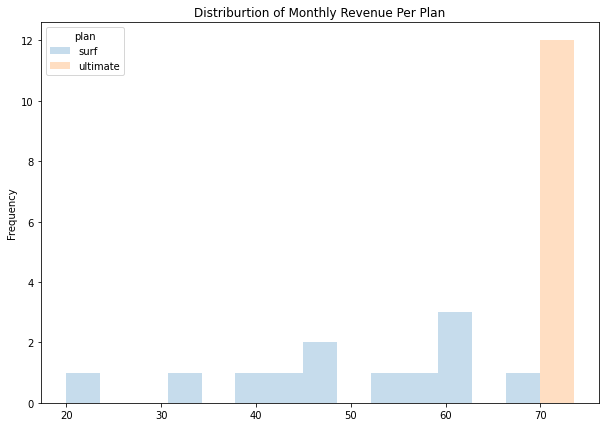

In [68]:
revenue_pivot.plot(kind='hist',
                   title='Distriburtion of Monthly Revenue Per Plan',
                   figsize=(10,7),
                   bins=15,
                   alpha=0.25);

We can infer that the majority of revenue comes from the Surf plans, since the base pay is greater, but the spread of data for the Surf plan users is wider. 

In [69]:
#calculating the standard deviation and variance of monthly revenue used per plan 
revenue_var_mean_pivot = df2.pivot_table(index='month',
                                      values='monthly_revenue_per_user',
                                      columns='plan',
                                      aggfunc=['var', 'std'])
revenue_var_mean_pivot

var                    std           
plan          surf    ultimate       surf   ultimate
month                                               
1.0       0.000000    0.000000   0.000000   0.000000
2.0     382.277778    0.000000  19.551925   0.000000
3.0    1417.272727  112.272727  37.646683  10.595883
4.0    1105.634286  117.528571  33.251079  10.841060
5.0    1831.260424    7.758621  42.793229   2.785430
6.0    1838.576246   61.603145  42.878622   7.848767
7.0    2815.191598  100.808884  53.058379  10.040363
8.0    3448.203205  139.382696  58.721403  11.806045
9.0    2112.379681   62.749658  45.960632   7.921468
10.0   3014.922227  152.958491  54.908307  12.367639
11.0   2349.895171   87.032496  48.475717   9.329121
12.0   4444.368629  197.959205  66.666098  14.069798

Monthly revenues for both plans have a high variance. 

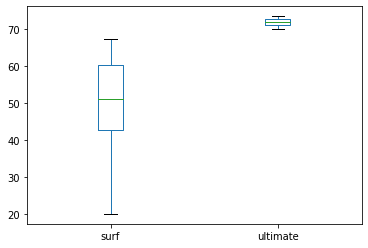

In [70]:
revenue_pivot.plot(kind='box');

More the Surf plan users data is spread out, while majority of Ultimate plan users are around 70, however, the range is very small. 

 #### Conclusion: The Ultimate plan users mean revenue per user is around 70. Surf Plan users range is wider. We can infer that more revenue comes from the Surf plan users. 

## Test statistical hypotheses

### First Hypothesis
The null hypothesis is that the average revenue from users of the Ultimate and Surf calling plans are the same.
The alternative hypothesis is that the average revenue from users of the Ultimate and Surf plan differs. 

In [71]:
# Test the hypotheses, creating a function to also test if variance is equal between the two populations
def t_test(sample1,sample2,alpha=0.05):
    p_value_levene=st.levene(sample1, sample2).pvalue.astype(int)
    
    if p_value_levene<alpha:
        option_var=False
    else:
        option_var=True
        
    p_value=st.ttest_ind(sample1, sample2, nan_policy='omit', equal_var=option_var).pvalue.astype(int)
    if p_value<alpha:
        print('We reject the null hypothesis: average of sample 1 is not equal to average of sample 2')
    else:
        print( "Fail to reject null hypothesis: We don't have enough evidence to say that averages of sample 1 \
        and sample 2 are not the same") 

In [72]:
#looking at the p-value alone
st.ttest_ind(revenue_pivot['surf'], revenue_pivot['ultimate']).pvalue

1.1657196927478248e-05

In [73]:
#applying t_test to revenue_pivot table for both plans 
t_test(revenue_pivot['surf'], revenue_pivot['ultimate'], alpha=0.05)

We reject the null hypothesis: average of sample 1 is not equal to average of sample 2


We can conclude from this test that the alternative hypothesis is true: the average revenue from users of the Ultimate and Surf calling plans differ.

### Second Hypothesis
The null hypothesis is that the average revenue from users in the NY-NY area is the same.
The alternative hypothesis is that the average revenue from users in the NY-NJ area is different from users in the other regions. 

In [74]:
#looking at the unique names of cities
df2['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [75]:
#splitting the city names to make locating easier 
split = df2['city'].str.split(pat=',', n=1, expand=True)
split

,0,1
0,Atlanta-Sandy Springs-Roswell,GA MSA
1,Seattle-Tacoma-Bellevue,WA MSA
2,Seattle-Tacoma-Bellevue,WA MSA
3,Seattle-Tacoma-Bellevue,WA MSA
4,Seattle-Tacoma-Bellevue,WA MSA
...,...,...
2298,Boston-Cambridge-Newton,MA-NH MSA
2299,Colorado Springs,CO MSA
2300,Denver-Aurora-Lakewood,CO MSA
2301,Atlanta-Sandy Springs-Roswell,GA MSA


In [76]:
#adding that column back into df3 at the end 
df2['region'] = split[0]
df2.head()

,user_id,month,total_calls,total_duration,total_texts,total_gb_used,first_name,last_name,age,city,reg_date,plan,churn_date,monthly_revenue_per_user,region
0,1000,12.0,16.0,124.0,11.0,1.856904,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,not_applicable,70.0,Atlanta-Sandy Springs-Roswell
1,1001,8.0,27.0,182.0,30.0,6.756982,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,20.0,Seattle-Tacoma-Bellevue
2,1001,9.0,49.0,315.0,44.0,13.002754,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,20.0,Seattle-Tacoma-Bellevue
3,1001,10.0,65.0,393.0,53.0,21.807119,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,89.0,Seattle-Tacoma-Bellevue
4,1001,11.0,64.0,426.0,36.0,18.070605,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,not_applicable,51.0,Seattle-Tacoma-Bellevue


In [77]:
#defining the two populations to test, one being NY-NJ and the other being the rest of the population
ny_nj = df2.query('region == "New York-Newark-Jersey City"')
other = df2.query('region != "New York-Newark-Jersey City"')

In [78]:
#looking at the p-value
st.ttest_ind(ny_nj['monthly_revenue_per_user'], other['monthly_revenue_per_user']).pvalue

0.03466119191909918

In [79]:
#applying T-Test into function defined above
t_test(ny_nj['monthly_revenue_per_user'], other['monthly_revenue_per_user'], alpha=0.05)

We reject the null hypothesis: average of sample 1 is not equal to average of sample 2


We can conclude from this test that the alternative hypothesis is true: the average revenue from users in the NY-NJ area is different from users in the other regions. 

In [80]:
#taking a quick look at some stats before making final conclusion 
compare

,sum,mean,median
plan,,,
surf,91436.0,57.907536,38.0
ultimate,52223.0,72.131215,70.0


In [81]:
df2.groupby('plan').mean()

,user_id,month,total_calls,total_duration,total_texts,total_gb_used,age,monthly_revenue_per_user
plan,,,,,,,,
surf,1242.940469,9.182454,59.811825,428.749523,31.159568,16.170199,44.382521,57.907536
ultimate,1253.356354,9.151389,60.626389,430.450000,37.551389,16.811230,47.685083,72.131215


#### We can conclude from the given data that Surf plan users create more revenue than Ultimate plan users. It seems that Ultimate plan users tend to stay within their monthly plan limits while Surf users tend to go over in their minutes and data usage.